
Data after cleaning: 106856 rows remaining


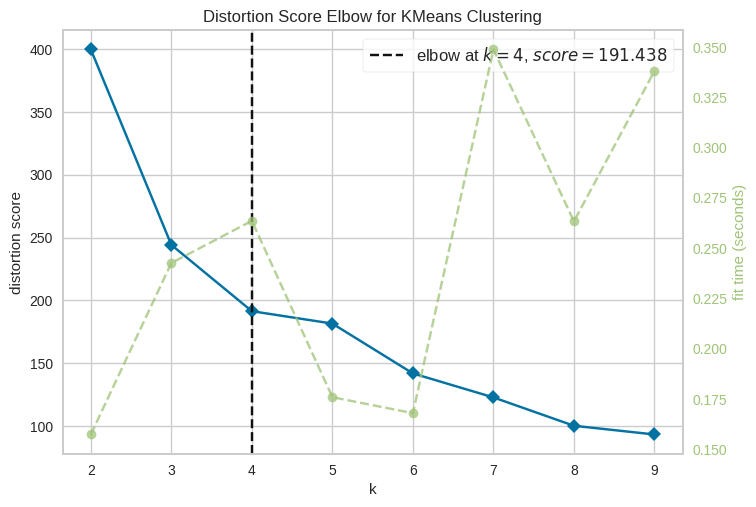

Optimal K: 4
        session_count                      total_duration              \
                  min max      mean    sum            min         max   
cluster                                                                 
0                   1   2  1.032746  41157         7189.0   1573420.0   
1                   2   4  2.157317  50300        18235.0   3174824.0   
2                   3  18  4.269306  17470        46896.0  18553754.0   
3                   1   2  1.010405  40008         7142.0   1375612.0   

                                     total_download                \
                  mean           sum            min           max   
cluster                                                             
0        106099.371851  4.228272e+09      8827082.0  4.757782e+08   
1        211119.982501  4.922474e+09    115111797.0  2.165972e+09   
2        570735.078446  2.335448e+09    525493344.0  8.156743e+09   
3        104370.240327  4.132644e+09    444852293.0  1.028018

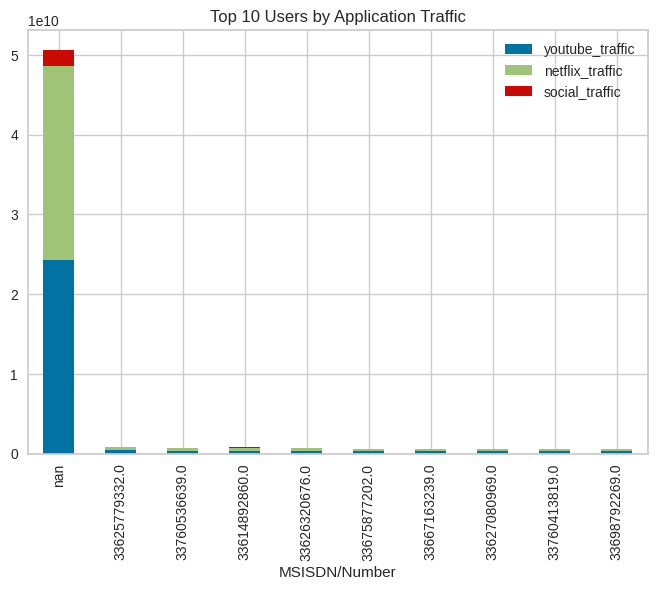

In [ ]:
from db_connection import fetch_data
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer

# SQL Query to Aggregate User Engagement Metrics
QUERY_ENGAGEMENT = """
SELECT "MSISDN/Number",
       COUNT(*) AS session_count,
       SUM("Dur. (ms)") AS total_duration,
       SUM("Total DL (Bytes)") AS total_download,
       SUM("Total UL (Bytes)") AS total_upload
FROM xdr_data
GROUP BY "MSISDN/Number"
ORDER BY session_count DESC;
"""

# Fetch Data
def load_engagement_data():
    return fetch_data(QUERY_ENGAGEMENT)

# Data Cleaning
def clean_engagement_data(df):
    df_cleaned = df.dropna(subset=["MSISDN/Number"]).copy()
    print(f"\nData after cleaning: {len(df_cleaned)} rows remaining")
    return df_cleaned

# Normalize Data for Clustering
def normalize_data(df):
    scaler = MinMaxScaler()
    scaled_features = scaler.fit_transform(df[['session_count', 'total_duration', 'total_download', 'total_upload']])
    return scaled_features

# Determine Optimal K using Elbow Method
def find_optimal_k(data):
    model = KMeans(random_state=42)
    visualizer = KElbowVisualizer(model, k=(2,10))
    visualizer.fit(data)
    visualizer.show()
    return visualizer.elbow_value_

# Perform K-means Clustering
def perform_clustering(df, scaled_data, k=3):
    kmeans = KMeans(n_clusters=k, random_state=42)
    df['cluster'] = kmeans.fit_predict(scaled_data)
    return df

# Aggregate Traffic by Application (SQL Query Example)
QUERY_APP_ENGAGEMENT = """
SELECT "MSISDN/Number",
       SUM("Youtube DL (Bytes)") + SUM("Youtube UL (Bytes)") AS youtube_traffic,
       SUM("Netflix DL (Bytes)") + SUM("Netflix UL (Bytes)") AS netflix_traffic,
       SUM("Social Media DL (Bytes)") + SUM("Social Media UL (Bytes)") AS social_traffic
FROM xdr_data
GROUP BY "MSISDN/Number"
ORDER BY youtube_traffic DESC;
"""

def load_application_engagement():
    return fetch_data(QUERY_APP_ENGAGEMENT)

# Visualize Top Applications
def visualize_top_apps(app_data):
    top_apps = app_data.head(10)
    top_apps.plot(x="MSISDN/Number", kind="bar", stacked=True)
    plt.title("Top 10 Users by Application Traffic")
    plt.show()

if __name__ == "__main__":
    # Load Data
    engagement_data = load_engagement_data()

    # Clean Data
    engagement_data_cleaned = clean_engagement_data(engagement_data)

    # Normalize Data
    normalized_data = normalize_data(engagement_data_cleaned)

    # Find Optimal K
    optimal_k = find_optimal_k(normalized_data)
    print(f"Optimal K: {optimal_k}")

    # Perform Clustering
    clustered_data = perform_clustering(engagement_data_cleaned, normalized_data, k=optimal_k)

    # Compute Cluster Stats
    cluster_summary = clustered_data.groupby('cluster').agg({
        'session_count': ['min', 'max', 'mean', 'sum'],
        'total_duration': ['min', 'max', 'mean', 'sum'],
        'total_download': ['min', 'max', 'mean', 'sum'],
        'total_upload': ['min', 'max', 'mean', 'sum']
    })
    print(cluster_summary)

    # Load Application Engagement
    app_engagement_data = load_application_engagement()
    
    # Visualize Application Traffic
    visualize_top_apps(app_engagement_data)